# Training Inception Model

This section will build a transfer learning model based on Inception (GoogLe Net) architecture.

#### Loading pre-processed data

In [ ]:
import boto3
import pandas as pd
import numpy as np

FILE_FOLDER = '../data/'
BUCKET_NAME = 'cse6250-chestxray'
IMAGE_IN_BUCKET = 'images/'

s3 = boto3.resource('s3')
bucket = s3.Bucket(BUCKET_NAME)

train_data = pd.read_csv(FILE_FOLDER + 'train_list.csv', header=0)
val_data = pd.read_csv(FILE_FOLDER + 'val_list.csv', header=0)
test_data = pd.read_csv(FILE_FOLDER + 'test_list.csv', header=0)
with open(FILE_FOLDER + 'labels.txt', 'r') as f:
    labels = f.readlines()

#### Define training functions

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import glob
import hashlib
import os.path
import random
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import tensor_shape
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

import struct

BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'
RESIZED_INPUT_TENSOR_NAME = 'ResizeBilinear:0'
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M
BOTTLENECK_TENSOR_SIZE = 2048
MODEL_INPUT_WIDTH = 299
MODEL_INPUT_HEIGHT = 299
MODEL_INPUT_DEPTH = 3
CACHED_GROUND_TRUTH_VECTORS = {}
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
LEARNING_RATE = 0.01
BATCH_SIZE = 64
NUM_ITERATION = 2000

MODEL_DIRECTORY = '../inception/model'
IMAGE_DIRECTORY = '../data/images'
BOTTLENET_DIRECTORY = '../inception/bottleneck'
TRAIN_DIRECTORY = '../inception/train'
VALIDATION_DIRECTORY = '../inception/validation'
OUTPUT_DIRECTORY = '../inception/model/'
IMAGE_IN_BUCKET = 'images/'
FINAL_TENSOR_NAME = 'final_result'

# create original inception net graph
def create_inception_graph():
    with tf.Session() as sess:
        model_filename = MODEL_DIRECTORY + '/classify_image_graph_def.pb'
        with gfile.FastGFile(model_filename, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            bottleneck_tensor, jpeg_data_tensor, resized_input_tensor = (
                tf.import_graph_def(graph_def, name='', return_elements=[
                    BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME, RESIZED_INPUT_TENSOR_NAME]))
    return sess.graph, bottleneck_tensor, jpeg_data_tensor, resized_input_tensor

# run original inception net on images
def run_bottleneck_on_image(sess, image_data, image_data_tensor, bottleneck_tensor):
    bottleneck_values = sess.run(
        bottleneck_tensor,
        {image_data_tensor: image_data})
    bottleneck_values = np.squeeze(bottleneck_values)
    return bottleneck_values

# download and extract original inception net graph
def maybe_download_and_extract():
    if not os.path.exists(MODEL_DIRECTORY):
        os.makedirs(MODEL_DIRECTORY)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(MODEL_DIRECTORY, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' %
                (filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

# cache results of running original inception net on images
def cache_static_bottlenecks(sess, image_lists, jpeg_data_tensor, bottleneck_tensor):
    how_many = 0
    for index, row in image_lists.iterrows():
        image_path = row.values[0].split('.')[0]
        bottleneck_path = BOTTLENET_DIRECTORY + '/' + image_path + '.txt'
        if not os.path.exists(bottleneck_path):
            image_file_path = IMAGE_DIRECTORY + '/' + row.values[0]
            print('Creating bottleneck at ' + bottleneck_path)
            if not gfile.Exists(image_file_path):
                with open(image_file_path, 'wb') as data:
                    bucket.download_fileobj(IMAGE_IN_BUCKET + row.values[0], data)
            image_data = gfile.FastGFile(image_file_path, 'rb').read()
            bottleneck_values = run_bottleneck_on_image(sess, image_data, jpeg_data_tensor, bottleneck_tensor)
            bottleneck_string = ','.join(str(x) for x in bottleneck_values)
            with open(bottleneck_path, 'w') as bottleneck_file:
                bottleneck_file.write(bottleneck_string)
        how_many += 1
        if how_many % 100 == 0:
            print(str(how_many) + ' bottleneck files created.')

# get/create results of running original inception net on images
def get_ordered_cached_bottlenecks(sess, image_lists, begin, end, jpeg_data_tensor, bottleneck_tensor, labels):
    bottlenecks = []
    ground_truths = []    
    for i in range(begin, end+1):
        image_path = image_lists.iloc[i].values[0].split('.')[0]
        
        bottleneck_path = BOTTLENET_DIRECTORY + '/' + image_path + '.txt'
        if not os.path.exists(bottleneck_path):
            print('Creating bottleneck at ' + bottleneck_path)
            image_file_path = IMAGE_DIRECTORY + '/' + image_lists.iloc[i].values[0]
            if not gfile.Exists(image_file_path):
                with open(image_file_path, 'wb') as data:
                    bucket.download_fileobj(IMAGE_IN_BUCKET + image_lists.iloc[i].values[0], data)
            image_data = gfile.FastGFile(image_file_path, 'rb').read()
            bottleneck_values = run_bottleneck_on_image(sess, image_data, jpeg_data_tensor, bottleneck_tensor)
            bottleneck_string = ','.join(str(x) for x in bottleneck_values)
            with open(bottleneck_path, 'w') as bottleneck_file:
                bottleneck_file.write(bottleneck_string)
        with open(bottleneck_path, 'r') as bottleneck_file:
            bottleneck_string = bottleneck_file.read()
        bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
        
        ground_truth = image_lists.iloc[i].values[1:].astype(np.float32)
        bottlenecks.append(bottleneck_values)
        ground_truths.append(ground_truth)
    return bottlenecks, ground_truths

# add variable summaries
def variable_summaries(var, name):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev/' + name, stddev)
        tf.summary.scalar('max/' + name, tf.reduce_max(var))
        tf.summary.scalar('min/' + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)

# add final fully connected layer to the model to train
def add_final_training_ops(class_count, final_tensor_name, bottleneck_tensor):
    with tf.name_scope('input'):
        bottleneck_input = tf.placeholder_with_default(bottleneck_tensor, shape=[None, BOTTLENECK_TENSOR_SIZE], name='BottleneckInputPlaceholder')
        ground_truth_input = tf.placeholder_with_default(np.zeros((BATCH_SIZE,class_count), dtype='float32'), [None, class_count], name='GroundTruthInput')

    # Organizing the following ops as `final_training_ops` so they're easier
    # to see in TensorBoard
    layer_name = 'final_training_ops'
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            layer_weights = tf.Variable(tf.truncated_normal([BOTTLENECK_TENSOR_SIZE, class_count], stddev=0.5), name='final_weights')
            variable_summaries(layer_weights, layer_name + '/weights')
        with tf.name_scope('biases'):
            layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
            variable_summaries(layer_biases, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases
            tf.summary.histogram(layer_name + '/pre_activations', logits)

    final_tensor = tf.nn.sigmoid(logits, name=final_tensor_name)
    tf.summary.histogram(final_tensor_name + '/activations', final_tensor)

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=ground_truth_input)
        with tf.name_scope('total'):
            cross_entropy_mean = tf.reduce_mean(cross_entropy)
        tf.summary.scalar('cross_entropy', cross_entropy_mean)

    with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy_mean)

    return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input, final_tensor)

# add evaluation step
def add_evaluation_step(result_tensor, ground_truth_tensor):
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct = tf.cast(tf.equal(tf.round(result_tensor), ground_truth_tensor), tf.float32)
            correct_prediction = tf.equal(tf.cast(tf.count_nonzero(correct, 1), tf.int32), tf.constant(14, shape=[BATCH_SIZE,1]))
        with tf.name_scope('accuracy'):
            evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', evaluation_step)
    return (evaluation_step, result_tensor, ground_truth_tensor)

#### Rebuild original image net graph

In [ ]:
maybe_download_and_extract()
graph, bottleneck_tensor, jpeg_data_tensor, resized_image_tensor = (create_inception_graph())
sess = tf.Session()

#### Cache bottleneck results on images

In [ ]:
cache_static_bottlenecks(sess, train_data, jpeg_data_tensor, bottleneck_tensor)
cache_static_bottlenecks(sess, val_data, jpeg_data_tensor, bottleneck_tensor)
cache_static_bottlenecks(sess, test_data, jpeg_data_tensor, bottleneck_tensor)

#### Add fully connected layer

In [ ]:
class_count = len(labels)

(train_step, cross_entropy, bottleneck_input, ground_truth_input, final_tensor) \
    = add_final_training_ops(class_count, FINAL_TENSOR_NAME, bottleneck_tensor)
evaluation_step = add_evaluation_step(final_tensor, ground_truth_input)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(TRAIN_DIRECTORY, sess.graph)
validation_writer = tf.summary.FileWriter(VALIDATION_DIRECTORY)
init = tf.global_variables_initializer()
sess.run(init)

#### Run training & save results

In [ ]:
train_entropy_list = []
train_accuracy_list = []
epoch = []
val_entropy_list = []
val_accuracy_list = []
best_accuracy = 0

for i in range(NUM_ITERATION):
    epoch.append(i)
    train_data = train_data.sample(frac=1)
    val_data = val_data.sample(frac=1)
    
    # train by batches
    for j in range(int(len(train_data)/BATCH_SIZE)):
        train_bottlenecks, train_ground_truth = get_ordered_cached_bottlenecks(
            sess, train_data, j*BATCH_SIZE, (j+1)*BATCH_SIZE-1,
            jpeg_data_tensor, bottleneck_tensor, labels)
        train_summary, _ = sess.run([merged, train_step],
                                    feed_dict={bottleneck_input: train_bottlenecks, ground_truth_input: train_ground_truth})
        train_writer.add_summary(train_summary, i)

    # evaluate training entropy & accuracy
    train_accumulated_entropy = []
    train_accumulated_accuracy = []
    for j in range(int(len(train_data)/BATCH_SIZE)):
        train_bottlenecks, train_ground_truth = get_ordered_cached_bottlenecks(
              sess, train_data, j*BATCH_SIZE, (j+1)*BATCH_SIZE-1,
              jpeg_data_tensor, bottleneck_tensor, labels)
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks, ground_truth_input: train_ground_truth})
        accuracy, predict, truth = train_accuracy
        train_accumulated_accuracy.append(accuracy)
        train_accumulated_entropy.append(cross_entropy_value)
    
    #evaluate validation entropy & accuracy
    val_accumulated_entropy = []
    val_accumulated_accuracy = []
    for k in range(int(len(val_data)/BATCH_SIZE)):
        validation_bottlenecks, validation_ground_truth = (
          get_ordered_cached_bottlenecks(
              sess, val_data, k*BATCH_SIZE, (k+1)*BATCH_SIZE-1,
              jpeg_data_tensor, bottleneck_tensor, labels))
        validation_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: validation_bottlenecks, ground_truth_input: validation_ground_truth})
        accuracy, predict, truth = validation_accuracy
        val_accumulated_accuracy.append(accuracy)
        val_accumulated_entropy.append(cross_entropy_value)
    
    # display each epoch result
    print(str(datetime.now()) + "  Epoch " + str(i) + ":")
    train_entropy_this = np.sum(train_accumulated_entropy)
    print(str(datetime.now()) + "  Train Entropy: " + str(train_entropy_this))
    train_entropy_list.append(train_entropy_this)
    train_accuracy_this = np.mean(train_accumulated_accuracy)
    print(str(datetime.now()) + "  Train Accuracy: " + str(train_accuracy_this))
    train_accuracy_list.append(train_accuracy_this)
    
    val_entropy_this = np.sum(val_accumulated_entropy)
    print(str(datetime.now()) + "  Validation Entropy: " + str(val_entropy_this))
    val_entropy_list.append(val_entropy_this)
    val_accuracy_this = np.mean(val_accumulated_accuracy)
    print(str(datetime.now()) + "  Validation Accuracy: " + str(val_accuracy_this))
    val_accuracy_list.append(val_accuracy_this)
    print("============================================")
    
    # save best accuracy
    if val_accuracy_this > best_accuracy:
        best_accuracy = val_accuracy_this
        output_graph_def = graph_util.convert_variables_to_constants(sess, \
                                graph.as_graph_def(), [FINAL_TENSOR_NAME])
        with gfile.FastGFile(OUTPUT_DIRECTORY + 'output_graph.pb', 'wb') as f:
            f.write(output_graph_def.SerializeToString())

# save training curves
result = pd.DataFrame({'epoch': epoch, 'train_entropy': train_entropy_list, 'train_accuracy': train_accuracy_list,
                       'val_entropy': val_entropy_list, 'val_accuracy': val_accuracy_list})
result.to_csv(OUTPUT_DIRECTORY + 'train_result.csv', sep=',', encoding='utf-8', index=False)

#### Run classification on test data

In [ ]:
truth = []
predict = []
for k in range(int(len(test_data)/BATCH_SIZE)):
    test_bottlenecks, test_ground_truth = get_ordered_cached_bottlenecks(
        sess, test_data, k*BATCH_SIZE, (k+1)*BATCH_SIZE-1,
        jpeg_data_tensor, bottleneck_tensor, labels)
    test_accuracy = sess.run(evaluation_step,
                             feed_dict={bottleneck_input: test_bottlenecks, ground_truth_input: test_ground_truth})
    accuracy, test_predict, test_truth = test_accuracy
    truth.extend(test_truth)
    predict.extend(test_predict)

#### Evaluate classification result
Evaluate Area Under ROC Curve metric for each class

Plotting ROC curves:


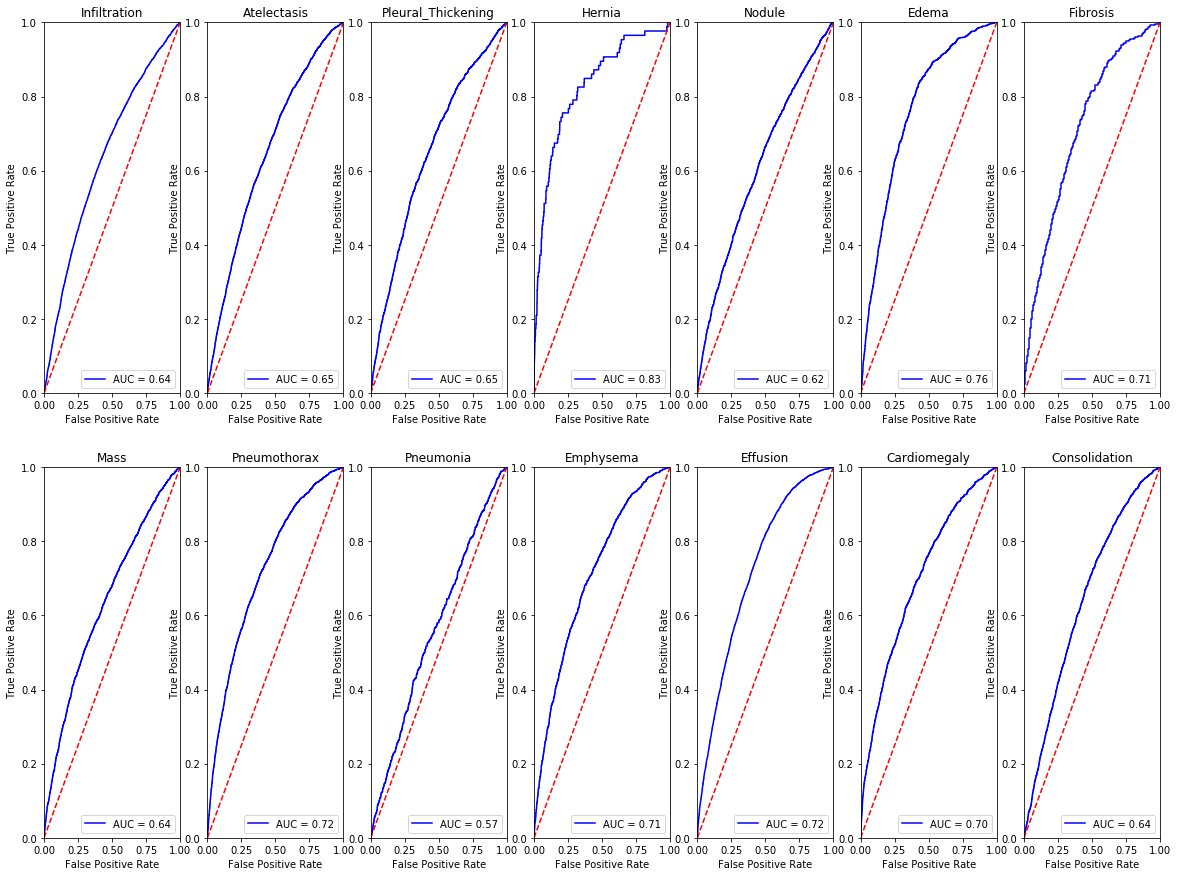

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt

auc_list = []
fpr_list = []
tpr_list = []
truth_list = []
predict_list = []

for i in range(14):
    each_truth = [x[i] for x in truth]
    each_predict = [y[i] for y in predict]
    fpr, tpr, thresholds = metrics.roc_curve(each_truth, each_predict)
    each_auc = metrics.auc(fpr, tpr)
    truth_list.append(each_truth)
    predict_list.append(each_predict)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(each_auc)

print("Plotting ROC curves:")

# create figure with sub-plots
fig, axes = plt.subplots(2, 7, figsize=(20,15))
for i, ax in enumerate(axes.flat):
    ax.plot(fpr_list[i], tpr_list[i], 'b', label = 'AUC = %0.2f' % auc_list[i])
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(labels[i])
plt.show()

Plotting AUCs:


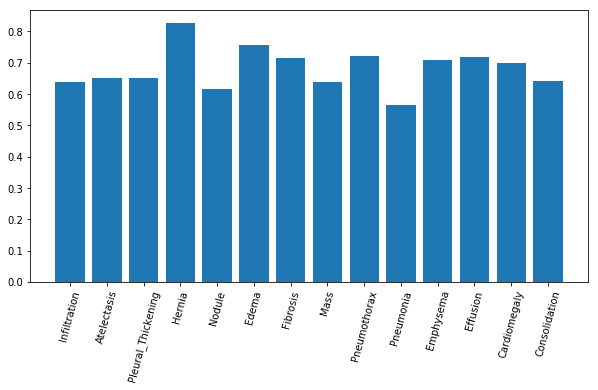

In [9]:
print("Plotting AUCs:")

plt.figure(figsize=(10,5))
plt.bar(labels, auc_list)
plt.xticks(rotation=75)
plt.show()

Thresholds can further be refined to enhance performance.

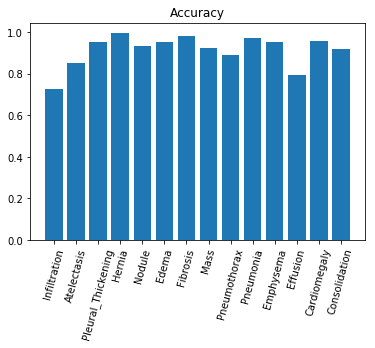

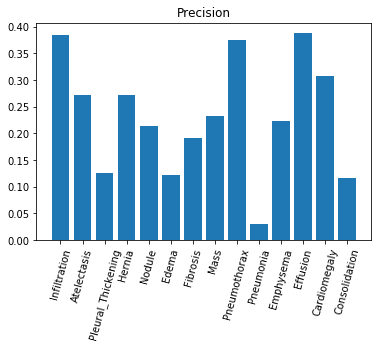

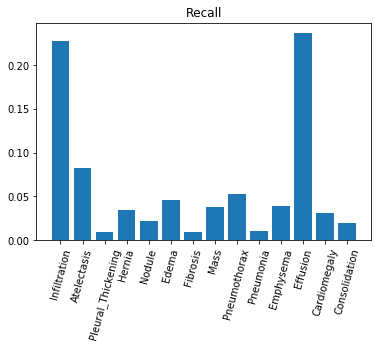

In [28]:
pred_0 = [int(z >= 0.4) for z in predict_list[0]]
pred_1 = [int(z >= 0.4) for z in predict_list[1]]
pred_2 = [int(z >= 0.4) for z in predict_list[2]]
pred_3 = [int(z >= 0.35) for z in predict_list[3]]
pred_4 = [int(z >= 0.4) for z in predict_list[4]]
pred_5 = [int(z >= 0.4) for z in predict_list[5]]
pred_6 = [int(z >= 0.4) for z in predict_list[6]]
pred_7 = [int(z >= 0.4) for z in predict_list[7]]
pred_8 = [int(z >= 0.4) for z in predict_list[8]]
pred_9 = [int(z >= 0.2) for z in predict_list[9]]
pred_10 = [int(z >= 0.4) for z in predict_list[10]]
pred_11 = [int(z >= 0.4) for z in predict_list[11]]
pred_12 = [int(z >= 0.4) for z in predict_list[12]]
pred_13 = [int(z >= 0.4) for z in predict_list[13]]
predict_label_list = [pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7,\
                      pred_8, pred_9, pred_10, pred_11, pred_12, pred_13]

accuracy_list = []
precision_list = []
recall_list = []

for i in range(14):
    accuracy = metrics.accuracy_score(truth_list[i], predict_label_list[i])
    accuracy_list.append(accuracy)
    precision = metrics.precision_score(truth_list[i], predict_label_list[i])
    precision_list.append(precision)
    recall = metrics.recall_score(truth_list[i], predict_label_list[i])
    recall_list.append(recall)

plt.figure(figsize=(6,4))
plt.bar(labels, accuracy_list)
plt.title("Accuracy")
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(labels, precision_list)
plt.title("Precision")
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(labels, recall_list)
plt.title("Recall")
plt.xticks(rotation=75)
plt.show()